# Assignment 3

## Printed copy due in class on November 14, 2018

You may work in pairs on this assignment. You are not permitted to discuss this assignment with anyone other than your partner or the instructors.

### Student 1: Dmitriy Timokhin
### Student 2: Hanson Egbert

# Question 1: Neural Networks by Hand

## Part A

Suppose we train a neural network using the ReLU activation function: 

$$ g(a) = \max(a, 0). $$

1. Draw the graph of $g(a)$. (Matplotlib plots are acceptable.)
2. What is the derivative $h = g'(a)$ in terms of the input $a$?
3. What is the derivative $h = g'(a)$ in terms of the input $h$?

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## 1)

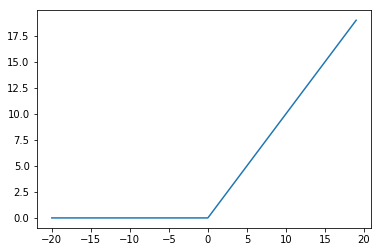

In [4]:
def ReLU(a): 
    return np.max([a, 0])

def ReLUderiv(a):
    if a <= 0:
        return 0
    else:
        return 1
ReLUderivVect = np.vectorize(ReLUderiv)

reluVect = np.vectorize(ReLU)
vals = np.arange(-20, 20)
plt.plot(vals, reluVect(vals));

## 2)

Derivative when a < 0: 0 <br>
Derivative when a  = 0: Undefined <br>
Derivative when a > 0: 1 <br>

## 3)
If h is 0: Then a must be < 0 <br>
If h is 1: Then a must be > 0 <br>

## Part B

Consider a neural network, where the current weights and biases are as follows. (Since this network is so simple, we omit the superscripts $w^{(m)}$ and $b^{(m)}$ that indicates which layer each weight/bias is in.)

![](../Data401Fall2018/neural_network.png)

The activation function used in the hidden layer is the ReLU activation function. 
**No activation function is used in the output layer.**

Predict the output for the input ${\bf x} = (-1, 1)$. 

In [5]:
## Since we are including Bias in our network the values of each layer will follow
## a format similar to g(wx + b) where g is the ReLU function as specified.

## We can create a vector for our first layer
x = np.matrix([-1 ,1]).T  # shape is 2, 1

## Weight matrix for layer 1
w1 = np.matrix([[-1,2], [1,0]])

## First layer (using ReLU function from previous problem)
a1 = np.matmul(w1, x)
h = reluVect(a1)

## Final Layer
w2 = np.matrix([1,-1])
out = np.matmul(w2, h)
out

matrix([[3]])

The predicted output for the input x = (-1, 1) will be 3.

## Part C

We are training the neural network from the previous part to minimize the loss function 

$$ L_i({\bf w}, {\bf b}) = (\hat y_i - y_i)^2. $$

You have a new training observation ${\bf x_i} = (-1, 1)$ and $y_i = 1$. 
Use one step of (stochastic) gradient descent to update the 6 weights (from the previous part) ${\bf w} = (w_{11}, w_{12}, w_{21}, w_{22}, w_1, w_2)$ and the 3 biases (from the previous part) ${\bf b} = (b_1, b_2, b)$, based on this single observation. Use a learning rate of $\eta = 0.25$.

In [6]:
## Since we are performing stochastic gradient descent on the neural network,
## we are in essense performing backpropogation.
## We can do this at each layer and reuse our stored values for future use.

lrate = 0.25
## Firstly we have our predicted yhat from our previous, part b, which we decided is 3
y = 1
yhat = 3
## This is our dl/dy value which will be useful later
dldy = 2 * (3 - 1)
## This is just the derivative of wh + b with respect to w which is h
dydw = h

#### Updating w1, and w2 (stored in w2 for my code)
w2_n = w2.T - lrate * dldy * dydw

## Updating the Bias term b
b_n = np.matrix([0]) - lrate * dldy * 1

### Updating w11, w12, w21, w22. We need dldy, dydh, and dhdw
## We can reuse dldy from the previous weight updates

## This is just the derivative of wh + b with respect to h so its just w
dydh = w2.T
## We know h is just h=g(wx + b) so dhdw
## is just g'(wx + b) * x
# dhdw - dhda dadw
dhda = ReLUderivVect(a1)
dadw = x.T
dhdw = dhda * dadw
w1_n = w1 - lrate * dldy * np.matrix(np.array(dydh) * np.array(dhda)) * dadw

#### Updating b1, b2
b_1_n = np.matrix([0,0]).T - lrate * dldy * dydh * 1

In [7]:
## Testing new Neural Network
h_n = reluVect(np.matmul(w1_n, x) + b_1_n)
out_n = np.matmul(w2_n.T, h_n) + b_n
out_n

matrix([[-1.]])

# Question 2: Implementing Neural Networks

This question will guide you through the implementation of a fully-connected neural network. Although the question is divided into parts, you need not do the parts in order. In fact, you may want to start with Part C (implementing the neural network itself) so that you see how the pieces fit together.

## Part A: Loss Functions

By subclassing the `Loss` class below, implement the squared-error loss function 

$$L({\bf \hat y}, {\bf y}) = \sum_i (\hat y_i - y_i)^2.$$

In [10]:
class Loss(object):
    
    def __call__(self, predicted, actual):
        """Calculates the loss as a function of the prediction and the actual.
        
        Args:
          predicted (np.ndarray, float): the predicted output labels
          actual (np.ndarray, float): the actual output labels
          
        Returns: (float) 
          The value of the loss for this batch of observations.
        """
        raise NotImplementedError
        
    def derivative(self, predicted, actual):
        """The derivative of the loss with respect to the prediction.
        
        Args:
          predicted (np.ndarray, float): the predicted output labels
          actual (np.ndarray, float): the actual output labels
          
        Returns: (np.ndarray, float) 
          The derivatives of the loss.
        """
        raise NotImplementedError
        
        
class SquaredErrorLoss(Loss):
    
    def __call__(self, predicted, actual):
        return np.sum(
            (predicted - actual) ** 2
        )
    
    def derivative(self, predicted, actual):
        return (
            2 * (predicted - actual)
        )

## Part B: Activation Functions

By subclassing the `ActivationFunction` class below, implement the ReLU and Sigmoid activation functions.

In [77]:
class ActivationFunction(object):
        
    def __call__(self, a):
        """Applies activation function to the values in a layer.
        
        Args:
          a (np.ndarray, float): the values from the previous layer (after 
            multiplying by the weights.
          
        Returns: (np.ndarray, float) 
          The values h = g(a).
        """
        return a
    
    def derivative(self, h):
        """The derivatives as a function of the outputs at the nodes.
        
        Args:
          h (np.ndarray, float): the outputs h = g(a) at the nodes.
          
        Returns: (np.ndarray, float) 
          The derivatives dh/da.
        """
        return np.ones(h.shape)
    
class ReLU(ActivationFunction):
    
    def __call__(self, a):
        return np.where(a > 0, a, 0)
    
    def derivative(self, a):
        return np.where(a > 0, 1, 0)

class Sigmoid(ActivationFunction):
    
    def __call__(self, a):
        return 1/(1 + np.exp(-a))
    
    def derivative(self, a):
        return  self.__call__(a) * (1 - self.__call__(a))

In [78]:
x = ActivationFunction()
x.derivative(np.array([1,2]))

array([ 1.,  1.])

## Part C: Putting It All Together

A `Layer` class has been completely implemented for you. This class applies the activation function to the incoming values and stores the current values at the layer. (We need to store the values because they come in handy when we are doing backpropagation.)

The `FullyConnectedNeuralNetwork` class is only partially implemented. You have to implement the `feedforward` and `backprop` methods.

In [199]:
class Layer(object):
    """A data structure for a layer in a neural network.
    
    Attributes:
      num_nodes (int): number of nodes in the layer
      activation_function (ActivationFunction)
      values_pre_activation (np.ndarray, float): most recent values
        in layer, before applying activation function
      values_post_activation (np.ndarray, float): most recent values
        in layer, after applying activation function
    """
    
    def __init__(self, num_nodes, activation_function=ActivationFunction()):
        self.num_nodes = num_nodes
        self.activation_function = activation_function
        
    def get_layer_values(self, values_pre_activation):
        """Applies activation function to values from previous layer.
        
        Stores the values (both before and after applying activation 
        function)
        
        Args:
          values_pre_activation (np.ndarray, float): 
            A (batch size) x self.num_nodes array of the values
            in layer before applying the activation function
        
        Returns: (np.ndarray, float)
            A (batch size) x self.num_nodes array of the values
            in layer after applying the activation function
        """
        self.values_pre_activation = values_pre_activation
        self.values_post_activation = self.activation_function(
            values_pre_activation
        )
        return self.values_post_activation

        
class FullyConnectedNeuralNetwork(object):
    """A data structure for a fully-connected neural network.
    
    Attributes:
      layers (Layer): A list of Layer objects.
      loss (Loss): The loss function to use in training.
      learning_rate (float): The learning rate to use in backpropagation.
      weights (list, np.ndarray): A list of weight matrices,
        length should be len(self.layers) - 1
      biases (list, float): A list of bias terms,
        length should be equal to len(self.layers)
    """
    
    def __init__(self, layers, loss, learning_rate):
        self.layers = layers
        self.loss = loss
        self.learning_rate = learning_rate
        
        # initialize weight matrices and biases to zeros
        self.weights = []
        self.biases = []
        for i in range(1, len(self.layers)):
            self.weights.append(
                np.zeros((self.layers[i - 1].num_nodes, self.layers[i].num_nodes))
            )
            self.biases.append(np.zeros(self.layers[i].num_nodes))
        print(self.biases)

    def feedforward(self, inputs):
        """Predicts the output(s) for a given set of input(s).
        
        Args:
          inputs (np.ndarray, float): A (batch size) x self.layers[0].num_nodes array
          
        Returns: (np.ndarray, float) 
          An array of the predicted output labels, length is the batch size
        """
        self.storedValues = []
        h = inputs
        ## Iterate layers
        for i, layer in enumerate(self.layers):
            ## g(hw + b),  h = previous layer values
            if i != len(self.layers) - 1:
                h = layer.get_layer_values(np.matrix(np.add(h * self.weights[i], np.matrix(self.biases[i]))))
        return h     
        
    def backprop(self, predicted, actual):
        """Updates self.weights and self.biases based on predicted and actual values.
        
        This will require using the values at each layer that were stored at the
        feedforward step.
        
        Args:
          predicted (np.ndarray, float): An array of the predicted output labels
          actual (np.ndarray, float): An array of the actual output labels
        """
        # TODO: Implement backpropagation.
        raise NotImplementedError
        
    def train(self, inputs, labels):
        """Trains neural network based on a batch of training data.
        
        Args:
          inputs (np.ndarray): A (batch size) x self.layers[0].num_nodes array
          labels (np.ndarray): An array of ground-truth output labels, 
            length is the batch size.
        """
        predicted = self.feedforward(inputs)
        self.backprop(predicted, labels)

In [200]:
x = Layer(2)
x.get_layer_values(np.array([1,2,3,-4]))

array([ 1,  2,  3, -4])

In [201]:
network = FullyConnectedNeuralNetwork(
    layers=[Layer(2), Layer(2, ReLU()), Layer(1)],
    loss = SquaredErrorLoss,
    learning_rate=0.25
)

[array([ 0.,  0.]), array([ 0.])]


In [203]:
network.feedforward(np.matrix([[-1, 1],[-2,4]]))

[[ 0.  0.]
 [ 0.  0.]]
[[ 0.]
 [ 0.]]


array([[ 0.],
       [ 0.]])

In [173]:
np.add(np.matrix([[1,2], [10,15]]), np.matrix([3,6]))

matrix([[ 4,  8],
        [13, 21]])

## Part D: Testing It Out

Try testing out your neural network implmentation on the simple neural network you considered in Question 1. The following code initializes a neural network with the structure of the network from Question 1. Note that all weights are initialized to zero.

In [ ]:
network = FullyConnectedNeuralNetwork(
    layers=[Layer(2), Layer(2, ReLU()), Layer(1)],
    learning_rate=0.25
)

network.train(np.array([[-1, 1]]), 1)